# Классификация комментариев в интернет-магазине

## Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import nltk
import spacy
import pandas as pd


from sklearn.svm import LinearSVC
from pandarallel import pandarallel
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    print('Ошибка загрузки данных')
    
display(data.head())
data.info()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


**Проверка данных пропуски и явные дубликаты**

In [5]:
print('Количество явных дубликатов:', data.duplicated().sum())
print()
print('Количество пропусков по столбцам', data.isna().sum(), sep='\n')

Количество явных дубликатов: 0

Количество пропусков по столбцам
Unnamed: 0    0
text          0
toxic         0
dtype: int64


**Проверка данных на дисбаланс в столбце с целевым признаком**

0    143106
1     16186
Name: toxic, dtype: int64



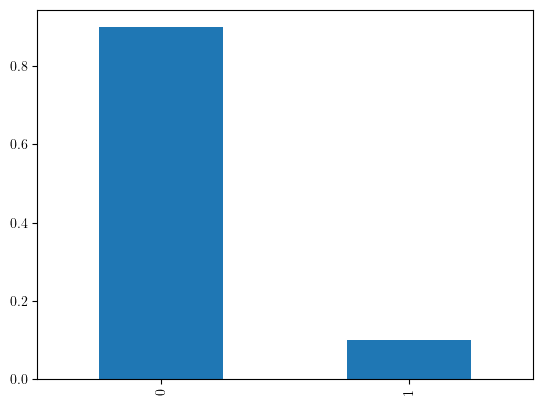

In [6]:
print(data['toxic'].value_counts(), end='\n\n')

class_frequency = data['toxic'].value_counts(normalize=True)
class_frequency.plot(kind='bar');

In [7]:
print(f'Отношение вероятности класса "0" к количеству класса "1": {143106 / 16186:.1f}')

Отношение вероятности класса "0" к количеству класса "1": 8.8


**Удаление неинформативных признаков**

In [8]:
data.drop('Unnamed: 0', axis=1, inplace=True)

**Очистка данных**

In [9]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', str(text).lower())
    return ' '.join(text.split())

In [10]:
data['text'] = data['text'].parallel_apply(clear_text)
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


**Лемматизация**

In [11]:
nlp = spacy.load('en_core_web_sm')

def lemm(text):
    nlp_text = nlp(text)
    return " ".join([token.lemma_ for token in nlp_text])

In [12]:
data['lemm_text'] = data['text'].parallel_apply(lemm)

In [13]:
data.head()

,text,toxic,lemm_text
0,explanation why the edits made under my userna...,0,explanation why the edit make under my usernam...
1,d aww he matches this background colour i m se...,0,d aww he match this background colour I m seem...
2,hey man i m really not trying to edit war it s...,0,hey man I m really not try to edit war it s ju...
3,more i can t make any real suggestions on impr...,0,more I can t make any real suggestion on impro...
4,you sir are my hero any chance you remember wh...,0,you sir be my hero any chance you remember wha...


**Вывод**

Была проведена предобработка данных: очистка и лемматизация. Обнаружен дисбаланс в столбце с целевым признаком.

## Обучение

**Разбиение на обучающую, валидационную и тестовую выборки**

In [15]:
features = data['lemm_text']
target = data['toxic']

#разбиение на обучающую (train) и валидационную+тестовую (validtest) выборки в отношении 60%:40%.

features_train, features_validtest, target_train, target_validtest = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)

# разбиение на валидационную (valid) и тестовую (test) выборки

features_valid, features_test, target_valid, target_test = train_test_split(
    features_validtest, target_validtest, test_size=0.5, random_state=12345, stratify=target_validtest)

**Вычисление TF-IDF для корпуса текста**

In [16]:
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))

vect = TfidfVectorizer(stop_words=stopwords)

features_train_vect = vect.fit_transform(features_train)
features_valid_vect = vect.transform(features_valid)
features_test_vect = vect.transform(features_test)

[nltk_data] Downloading package stopwords to /home/rustam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**МОДЕЛЬ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ**

In [17]:
model_lr = LogisticRegression(class_weight='balanced', random_state=12345, max_iter=200)
model_lr.fit(features_train_vect, target_train)

print('Метрика качества модели F1 на валидационной выборке: {:.4f}'.
      format(f1_score(target_valid, model_lr.predict(features_valid_vect))))

Метрика качества модели F1 на валидационной выборке: 0.7588


**МОДЕЛЬ LinearSVC**

In [21]:
model_lin = LinearSVC(class_weight='balanced', random_state=12345, max_iter=1500)
model_lin.fit(features_train_vect, target_train)

print('Метрика качества модели F1 на валидационной выборке: {:.4f}'.
      format(f1_score(target_valid, model_lin.predict(features_valid_vect))))

Метрика качества модели F1 на валидационной выборке: 0.7656


**Вывод**

Средняя оценка метрики качества F1 для обеих моделей превышает заданный порог: 0.7588 для модели логистической регрессии и 0.7656 для модели LinearSVC.

## Тестирование

In [22]:
model_lin = LinearSVC(class_weight='balanced', random_state=12345, max_iter=1500)
model_lin.fit(features_train_vect, target_train)


print('Значение метрики качества модели F1 для тестовых данных: {:.4f}'.
      format(f1_score(target_test, model_lin.predict(features_test_vect))))

Значение метрики качества модели F1 для тестовых данных: 0.7538


## Выводы

При выборе из двух моделей (модель логистической регрессии и модель LinearSVC) более эффективной является модель LinearSVC: значение метрики качества модели F1 на валидационной выборке составила 0.7656, значение метрики качества F1 для тестовых данных составило 0.7538.